# Vortex sheet behind elliptically loaded wing

In [102]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
using PotentialFlow
# pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [267]:
tf = 0.05

0.05

## PotentialFlow.jl

In [268]:
N = 200
α = range(0, π, length = 2N+1)
zs = complex.(cos.(α)).+(2.0+2.0im)
Γs = sin.(α)
δ = 0.025;
Δt = 0.001;

In [269]:
function compute_ẋ!(ẋ, x, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

In [270]:
sheet₋ = Vortex.Sheet(zs, Γs, δ)
sheet₊ = deepcopy(sheet₋)
ẋs = [allocate_velocity(sheet₋) for k in 1:4];
for t in 0:Δt:tf
    rk4!(sheet₊, sheet₋, t, Δt, compute_ẋ!, advect!, ẋs)
    Vortex.Sheets.filter!(sheet₊, 0.2δ, 0.4δ)
    sheet₊, sheet₋ = sheet₋, sheet₊
end

## ViscousFlow.jl

In [271]:
mutable struct PointVortex
    x::Real
    y::Real
    Γ::Real
end

### Eulerian grid

In [272]:
nx = 128; ny = 128;
Lx = 4.0;
dx = Lx/(nx-2);
display(dx)
s = Nodes(Dual,(nx,ny));
q = Edges(Primal,(nx,ny));
ψ = Nodes(Dual,s);
L = plan_laplacian(size(s),with_inverse=true)
L⁻¹(s::T) where {T} = L\s;

0.031746031746031744

### Problem parameters

In [273]:
nvortices = 1000
xmin_sheet = 1.0
xmax_sheet = 3.0
y_sheet = 2.0
Γ(x) = -(1-(x-2.0)^2)^0.5
tloc = 0.0

0.0

### Vortex sheet

In [274]:
vortices = Array{PointVortex,1}()
x_sheet = range(xmin_sheet, xmax_sheet, length=nvortices)
dx_sheet = x_sheet[2]-x_sheet[1]

# First vortex
vortex = PointVortex(x_sheet[1],y_sheet,0.5*(Γ(x_sheet[2])-Γ(x_sheet[1])))
push!(vortices,vortex)
# Middle vortices
for i in 2:nvortices-1
    vortex = PointVortex(x_sheet[i],y_sheet,0.5*(Γ(x_sheet[i+1])-Γ(x_sheet[i-1])))
    push!(vortices,vortex)
end
# Last vortex
vortex = PointVortex(x_sheet[nvortices],y_sheet,0.5*(Γ(x_sheet[nvortices])-Γ(x_sheet[nvortices-1])))
push!(vortices,vortex);

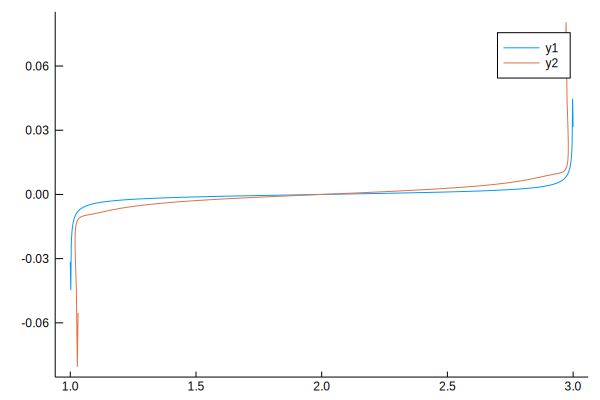

In [275]:
plot(x_sheet,[vortex.Γ for vortex in vortices])
plot!(real((v->v.z).(sheet₋.blobs)),(v->v.S).(sheet₋.blobs))

# plot(x_sheet,-Γ.(x_sheet))
# plot!(real((v->v.z).(sheet₊.blobs)),(sheet₊.Ss))

In [276]:
function rhs(vel::VectorData,vortices_loc::VectorData,params::Tuple{Nodes,Edges,ScalarData},t)
    
    
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve for streamfunction
    s .= -(L\(s)); 
    
    # Calculate velocity field
    q .= curl(s)/(dx);
        
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((s),q.u);
    Hw(vel.u,s)
    Fields.interpolate!((s),q.v);
    Hw(vel.v,s)
    
end 

rhs (generic function with 1 method)

### Time marching

In [277]:
tspan = (0.0,tf);#0.25
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
# u0 = [vortices_loc.u vortices_loc.v]
prob = ODEProblem(rhs,vortices_loc,tspan,(s,q,vortices_Γ))

ODEProblem with uType VectorData{1000} and tType Float64. In-place: true
timespan: (0.0, 0.05)
u0: [1.0, 1.002, 1.004, 1.00601, 1.00801, 1.01001, 1.01201, 1.01401, 1.01602, 1.01802  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [278]:
sol = solve(prob,RK4(),dense=false);

### Plot results

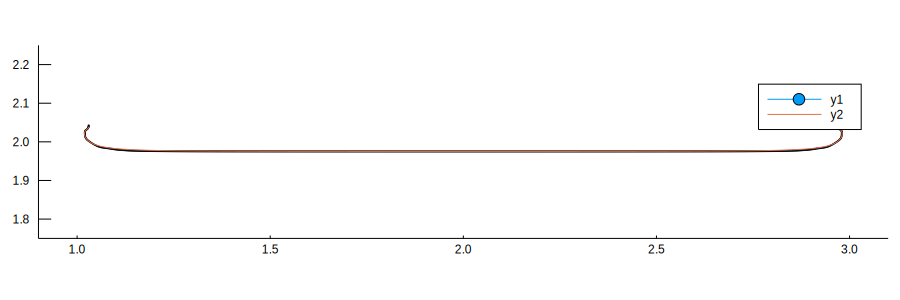

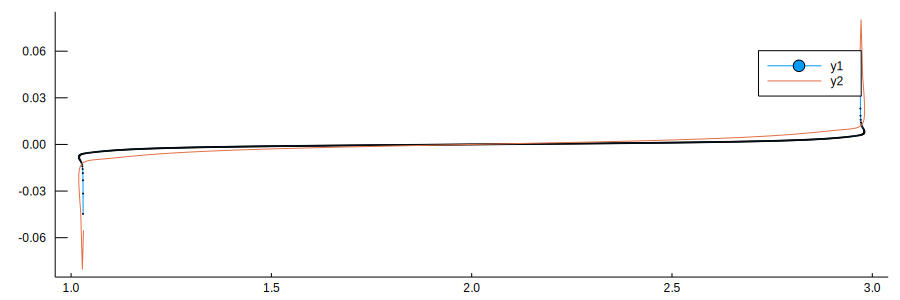

In [279]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]

matched_tuples = [(i,i+nvortices) for i in 1:nvortices]

#==============================PLOT VORTEX SHEET POSITION================================#

p4 = #plot(xg,yg,s,levels=20);
plot(xlims=(0.9,3.1),ylims=(1.75,2.25))
#ViscousFlow
plot!(sol[end].u,sol[end].v,markershape=:circle,markersize=0.3,ratio=1,size=[900,300])
#PotentialFlow
plot!(real((v->v.z).(sheet₋.blobs)),imag((v->v.z).(sheet₋.blobs)))

#==============================PLOT VORTEX SHEET STRENGTH================================#

#ViscousFlow
p5 = plot(sol[end].u,vortices_Γ,markershape=:circle,markersize=0.3,size=[900,300])
#PotentialFlow
plot!(real((v->v.z).(sheet₋.blobs)),(v->v.S).(sheet₋.blobs))


display(p4)
display(p5)


In [254]:
# paired_indices = nvortices
# plots_array = Array{Plots.Plot,1}()

# for i in 1:nvortices
#     p = scatter(first.(coord)[:],last.(coord)[:],ratio=:equal,markersize=1)
#     plot!(sol,vars=(i,i+nvortices),lw=2)
#     scatter!([sol[end][i]],[sol[end][i+nvortices]])
#     xlims!(minimum(sol[i,:])-1*dx,maximum(sol[i,:])+1*dx)
#     ylims!(minimum(sol[i+nvortices,:])-1*dx,maximum(sol[i+nvortices,:])+1*dx)
#     push!(plots_array,p)
# end

# p3 = plot(plots_array...,layout=(1,nvortices),size=[800,400])
# savefig("vortex_pair_rotating_goza_trajectories.pdf")

# display(p3)

### Analytical results

In [108]:
d = sqrt((vortices[1].x-vortices[2].x)^2 + (vortices[1].y-vortices[2].y)^2)

0.5

#### Opposite circulation

In [109]:
U = vortices[1].Γ/(4π*d)
println("Analytical self-induced velocity = $U")
println("Analytical distance traveled = $(U*tf)")
println("Numerical distance traveled = $(sol[1][1]-sol[end][1])")

Analytical self-induced velocity = 0.15915494309189535
Analytical distance traveled = 0.784633869443044
Numerical distance traveled = 0.002885700269819935


#### Equal circulation

In [111]:
T = 2π^2*d^2/vortices[1].Γ
println("Analytical period = $T")

Analytical period = 4.934802200544679


In [70]:
0.050550532375431945/1.5915494309189535

0.031761836229142

In [71]:
dx*2

0.031746031746031744

In [248]:
function lorenz(testdu,u,p,t)
 testdu[1] = 10.0*(u[2]-u[1])
 testdu[2] = u[1]*(28.0-u[3]) - u[2]
 testdu[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz (generic function with 1 method)

In [249]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,1.0)
prob = ODEProblem(lorenz,u0,tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: [1.0, 0.0, 0.0]

In [250]:
sol = solve(prob)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 28-element Array{Float64,1}:
 0.0                  
 3.5678604836301404e-5
 0.0003924646531993154
 0.0032624016752212923
 0.00905808176456279  
 0.0169564955927642   
 0.02769000245764448  
 0.04185634375662893  
 0.06024025665362463  
 0.0836852441654334   
 0.11336451506889586  
 0.14862131186030308  
 0.18703929175446188  
 ⋮                    
 0.3722098913969515   
 0.42013571940411776  
 0.46371861478076454  
 0.5049442389863666   
 0.5570599548490927   
 0.6068364009391921   
 0.6690177692283815   
 0.7276616574784435   
 0.7988511236820154   
 0.8763173594796152   
 0.9661595671190406   
 1.0                  
u: 28-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]                    
 [0.999643, 0.000998805, 1.78143e-8]
 [0.996105, 0.0109654, 2.14696e-6]  
 [0.969359, 0.0897704, 0.000143801] 
 [0.924204, 0.242289, 0.00104616]   
 [0.880045, 0.438737, 0.00342427]   
 [0.848331, 0.691564, 0.00848765]  